In [1]:
# Importing required Libraries

import plotly
import itertools
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import seaborn as sns
import cufflinks as cf
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
cf.go_offline(connected=True)
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from xgboost import XGBRegressor
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn import metrics
from sklearn import preprocessing
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Importing the data

df_sales = pd.read_csv("/Users/satishreddychirra/Document/DS5500 Data Visualization/Sales_Multiseries.csv")


In [3]:
df_sales.head()

,Store,Date,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Pct_Promotional,Econ_ChangeGDP,EconJobsChange,AnnualizedCPI
0,Louisville,07/01/12,76819.40,20100,42,1.03,327,9.96,July In Store Credit Card Signup Discount; In ...,0,0,No,No,0.000047,0.5,NaN,0.02
1,Louisville,07/02/12,78963.86,20100,21,0.41,293,8.65,July In Store Credit Card Signup Discount; In ...,0,0,No,No,0.000047,NaN,NaN,NaN
2,Louisville,07/03/12,74824.71,20100,26,0.31,356,8.96,July In Store Credit Card Signup Discount; In ...,0,0,No,No,0.000047,NaN,NaN,NaN
3,Louisville,07/04/12,78523.92,20100,33,0.83,350,10.08,July In Store Credit Card Signup Discount; In ...,0,0,Yes,No,0.000047,NaN,NaN,NaN
4,Louisville,07/05/12,76445.90,20100,38,0.51,299,9.80,July In Store Credit Card Signup Discount; ID5...,0,0,No,No,0.000047,NaN,NaN,NaN


In [4]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7140 entries, 0 to 7139
Data columns (total 17 columns):
Store               7140 non-null object
Date                7140 non-null object
Sales               7140 non-null float64
Store_Size          7140 non-null int64
Num_Employees       7140 non-null int64
Returns_Pct         7140 non-null float64
Num_Customers       7140 non-null int64
Pct_On_Sale         7130 non-null float64
Marketing           7140 non-null object
Near_Xmas           7140 non-null int64
Near_BlackFriday    7140 non-null int64
Holiday             7140 non-null object
DestinationEvent    7140 non-null object
Pct_Promotional     7140 non-null float64
Econ_ChangeGDP      80 non-null float64
EconJobsChange      1020 non-null float64
AnnualizedCPI       240 non-null float64
dtypes: float64(7), int64(5), object(5)
memory usage: 948.4+ KB


In [5]:
df_sales.describe()

,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Near_Xmas,Near_BlackFriday,Pct_Promotional,Econ_ChangeGDP,EconJobsChange,AnnualizedCPI
count,7140.000000,7140.000000,7140.000000,7140.000000,7140.000000,7130.000000,7140.000000,7140.000000,7140.000000,80.00000,1020.000000,240.000000
mean,78534.278832,16910.000000,35.048739,0.769146,269.444258,11.711823,2.691877,0.179272,0.065318,1.76250,-590.686275,0.019447
std,27445.616100,1927.023634,19.238847,0.469912,226.393313,3.861841,6.958566,0.965183,0.033369,1.84661,5970.650044,0.025387
min,0.000000,13400.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001119,-1.20000,-26000.000000,-0.034766
25%,61759.032500,15700.000000,23.000000,0.440000,154.000000,8.940000,0.000000,0.000000,0.047338,0.40000,-4250.000000,0.009091
50%,70776.860000,16750.000000,31.000000,0.680000,207.000000,10.940000,0.000000,0.000000,0.058358,1.80000,-250.000000,0.020241
75%,85319.047500,18800.000000,41.000000,1.000000,287.000000,13.717500,0.000000,0.000000,0.075387,3.32500,3000.000000,0.028015
max,324414.440000,20100.000000,214.000000,3.090000,2268.000000,31.070000,31.000000,8.000000,0.163078,4.00000,16500.000000,0.073502


In [6]:
# Extracting date columns

df_sales.Date = pd.to_datetime(df_sales.Date, format='%m/%d/%y')
df_sales['year'] = pd.DatetimeIndex(df_sales.Date).year
df_sales['month'] = pd.DatetimeIndex(df_sales.Date).month
df_sales['day'] = pd.DatetimeIndex(df_sales.Date).day
df_sales['dayOfWeek'] = pd.DatetimeIndex(df_sales.Date).dayofweek
df_sales['quarter'] = pd.DatetimeIndex(df_sales.Date).quarter


In [7]:
## Feature Engineering

# Deriving rolling Columns
def rollingColumns(df, groupbyCol, column, shiftNum, period):
    df[column+'_'+str(period)+'day_median'] = df.groupby(groupbyCol)[[column]].shift(
        shiftNum).rolling(period, min_periods=1).median().reset_index(0, drop=True)
    df[column+'_'+str(period)+'day_mean'] = df.groupby(groupbyCol)[[column]].shift(
        shiftNum).rolling(period, min_periods=1).mean().reset_index(0, drop=True)
    df[column+'_'+str(period)+'day_std'] = df.groupby(groupbyCol)[[column]].shift(
        shiftNum).rolling(period, min_periods=1).std().reset_index(0, drop=True)
    df[column+'_'+str(period)+'day_min'] = df.groupby(groupbyCol)[[column]].shift(
        shiftNum).rolling(period, min_periods=1).min().reset_index(0, drop=True)
    df[column+'_'+str(period)+'day_max'] = df.groupby(groupbyCol)[[column]].shift(
        shiftNum).rolling(period, min_periods=1).max().reset_index(0, drop=True)
    return df

# Deriving lag columns
def lagColumns(df, column, num):
    df[column+"_lag"+str(num)] = df.groupby('Store')[[column]].shift(num)
    return df

# Deriving diff Columns of the first lag
def diffColumns(df, column, num):
    df[column+"_diff"+str(num)] = df.groupby('Store')[[column]].shift(1).diff(num)
    return df


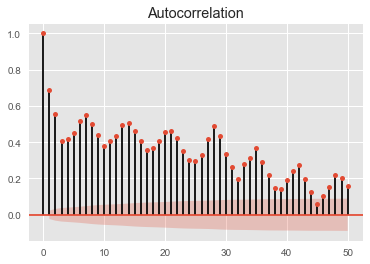

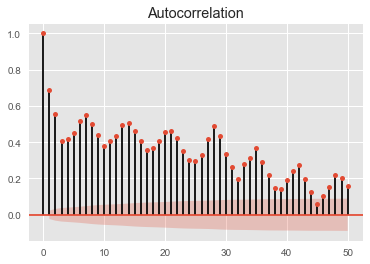

In [8]:
# Autocorrelation of the target feature

sm.tsa.graphics.plot_acf(df_sales['Sales'], lags=50)


In [9]:
# Target Derived Columns

# Moving Averages based 
mvPeriods = [7, 14, 21, 28]
for i in mvPeriods:
    df_sales = rollingColumns(df_sales, 'Store', 'Sales', 1, i)
    
# Lags 
lagPeriods = [1, 2, 3, 4, 5, 6, 7]
for i in lagPeriods:
    df_sales = lagColumns(df_sales, 'Sales', i)

# Diff columns
df_sales = diffColumns(df_sales, 'Sales', 1)

In [10]:
# Target derived columns

targetCols = [col for col in df_sales.columns if "Sales" in col]
df_sales[targetCols].head(10)

,Sales,Sales_7day_median,Sales_7day_mean,Sales_7day_std,Sales_7day_min,Sales_7day_max,Sales_14day_median,Sales_14day_mean,Sales_14day_std,Sales_14day_min,...,Sales_28day_min,Sales_28day_max,Sales_lag1,Sales_lag2,Sales_lag3,Sales_lag4,Sales_lag5,Sales_lag6,Sales_lag7,Sales_diff1
0,76819.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,78963.86,76819.40,76819.400000,NaN,76819.40,76819.40,76819.400,76819.400000,NaN,76819.40,...,76819.40,76819.40,76819.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,74824.71,77891.63,77891.630000,1516.362208,76819.40,78963.86,77891.630,77891.630000,1516.362208,76819.40,...,76819.40,78963.86,78963.86,76819.40,NaN,NaN,NaN,NaN,NaN,2144.46
3,78523.92,76819.40,76869.323333,2070.026554,74824.71,78963.86,76819.400,76869.323333,2070.026554,74824.71,...,74824.71,78963.86,74824.71,78963.86,76819.40,NaN,NaN,NaN,NaN,-4139.15
4,76445.90,77671.66,77282.972500,1881.779961,74824.71,78963.86,77671.660,77282.972500,1881.779961,74824.71,...,74824.71,78963.86,78523.92,74824.71,78963.86,76819.40,NaN,NaN,NaN,3699.21
5,85096.96,76819.40,77115.558000,1672.112419,74824.71,78963.86,76819.400,77115.558000,1672.112419,74824.71,...,74824.71,78963.86,76445.90,78523.92,74824.71,78963.86,76819.40,NaN,NaN,-2078.02
6,86807.56,77671.66,78445.791667,3585.233270,74824.71,85096.96,77671.660,78445.791667,3585.233270,74824.71,...,74824.71,85096.96,85096.96,76445.90,78523.92,74824.71,78963.86,76819.40,NaN,8651.06
7,78133.71,78523.92,79640.330000,4549.729019,74824.71,86807.56,78523.920,79640.330000,4549.729019,74824.71,...,74824.71,86807.56,86807.56,85096.96,76445.90,78523.92,74824.71,78963.86,76819.40,1710.60
8,74186.36,78523.92,79828.088571,4439.701372,74824.71,86807.56,78328.815,79452.002500,4245.777242,74824.71,...,74824.71,86807.56,78133.71,86807.56,85096.96,76445.90,78523.92,74824.71,78963.86,-8673.85
9,73390.55,78133.71,79145.588571,4934.356698,74186.36,86807.56,78133.710,78866.931111,4342.127717,74186.36,...,74186.36,86807.56,74186.36,78133.71,86807.56,85096.96,76445.90,78523.92,74824.71,-3947.35


In [11]:
# Calculating Moving averages for quantitative features

quantitativeCols = ['Store_Size', 'Num_Employees', 'Returns_Pct', 'Num_Customers', 'Pct_On_Sale', 'Pct_Promotional']

for col in quantitativeCols:
    for i in mvPeriods:
        df_sales = rollingColumns(df_sales, 'Store', col, 0, i)

In [12]:
# Calculating lags for quantitative features

for col in quantitativeCols:
    for i in lagPeriods:
        df_sales = lagColumns(df_sales, col, i)

In [13]:
# Calculating diff columns for quantitative features

for col in quantitativeCols:
        df_sales = diffColumns(df_sales, col, 1)


In [14]:
# One-Hot encoding for 'Store'

df_sales[list(pd.get_dummies(df_sales.Store).columns)] = pd.get_dummies(df_sales.Store)


In [15]:
# Converting features 'Holiday' and 'DestinationEvent' to numerical

df_sales['Holiday'] = np.where(df_sales['Holiday'] == 'Yes', 1, 0)
df_sales['DestinationEvent'] = np.where(df_sales['DestinationEvent'] == 'Yes', 1, 0)


In [16]:
### Feature Engineering in progress

# Word2Vec model (Google/Wiki/Train)

def remove_stopwords(sentence, language):
    tokenizer = RegexpTokenizer(r'\w+')
    return [token for token in tokenizer.tokenize(sentence) if token.lower() not in stopwords.words(language)]


# PCA to get Principle components



In [17]:
# Taking the length of text feature 'Marketing'

df_sales['MarketingLen'] = [len(text) for text in df_sales['Marketing']]


In [18]:
# Using Forward filling to minimize nan values for the economic indicator features

df_sales['Econ_ChangeGDP'] = df_sales['Econ_ChangeGDP'].fillna(method='ffill')
df_sales['EconJobsChange'] = df_sales['EconJobsChange'].fillna(method='ffill')
df_sales['AnnualizedCPI'] = df_sales['AnnualizedCPI'].fillna(method='ffill')


In [19]:
# Printing the shape of dataframe

df_sales.shape

(7140, 229)

In [20]:
# Dividing the data into train and test

train, test = df_sales[df_sales.Date < '2014-01-01'], df_sales[df_sales.Date >= '2014-01-01']

train.shape, test.shape

((5490, 229), (1650, 229))

In [21]:
train.groupby('Store')[['Sales']].count()

,Sales
Store,
Baltimore,549
Columbus,549
Detroit,549
Lancaster,549
Louisville,549
Philadelphia,549
Portland,549
Richmond,549
San Antonio,549


In [22]:
test.groupby('Store')[['Sales']].count()

,Sales
Store,
Baltimore,165
Columbus,165
Detroit,165
Lancaster,165
Louisville,165
Philadelphia,165
Portland,165
Richmond,165
San Antonio,165


In [23]:
# Dividing features and target for both train and test datasets

X_train, Y_train = train.drop('Sales', axis=1), train.Sales
X_test, Y_test = test.drop('Sales', axis=1), test.Sales


In [24]:
# Droping columns 'Date', 'Store' and 'Marketing'

X_train.drop(['Date','Store','Marketing'], axis=1, inplace=True)
X_test.drop(['Date','Store','Marketing'], axis=1, inplace=True)

In [25]:
# Printing the shapes

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((5490, 225), (5490,), (1650, 225), (1650,))

In [26]:
# Normalizing the train data

scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train.fillna(0))


In [27]:
model = XGBRegressor(max_depth=5, learning_rate=0.05, n_estimators=100, n_jobs=-1)

In [28]:
model.fit(X_train_scaled, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [29]:
# Normalizing test data

X_test_scaled = scaler.transform(X_test.fillna(0))

In [30]:
# Prediction on test data 

y_pred = model.predict(X_test_scaled)


In [31]:
## Evaluation Metrics 

# Variance Score

metrics.explained_variance_score(Y_test, y_pred)

0.9012305677665564

In [32]:
# RMSE

np.sqrt(metrics.mean_squared_error(Y_test, y_pred))

6187.863277809576

<Figure size 432x288 with 0 Axes>

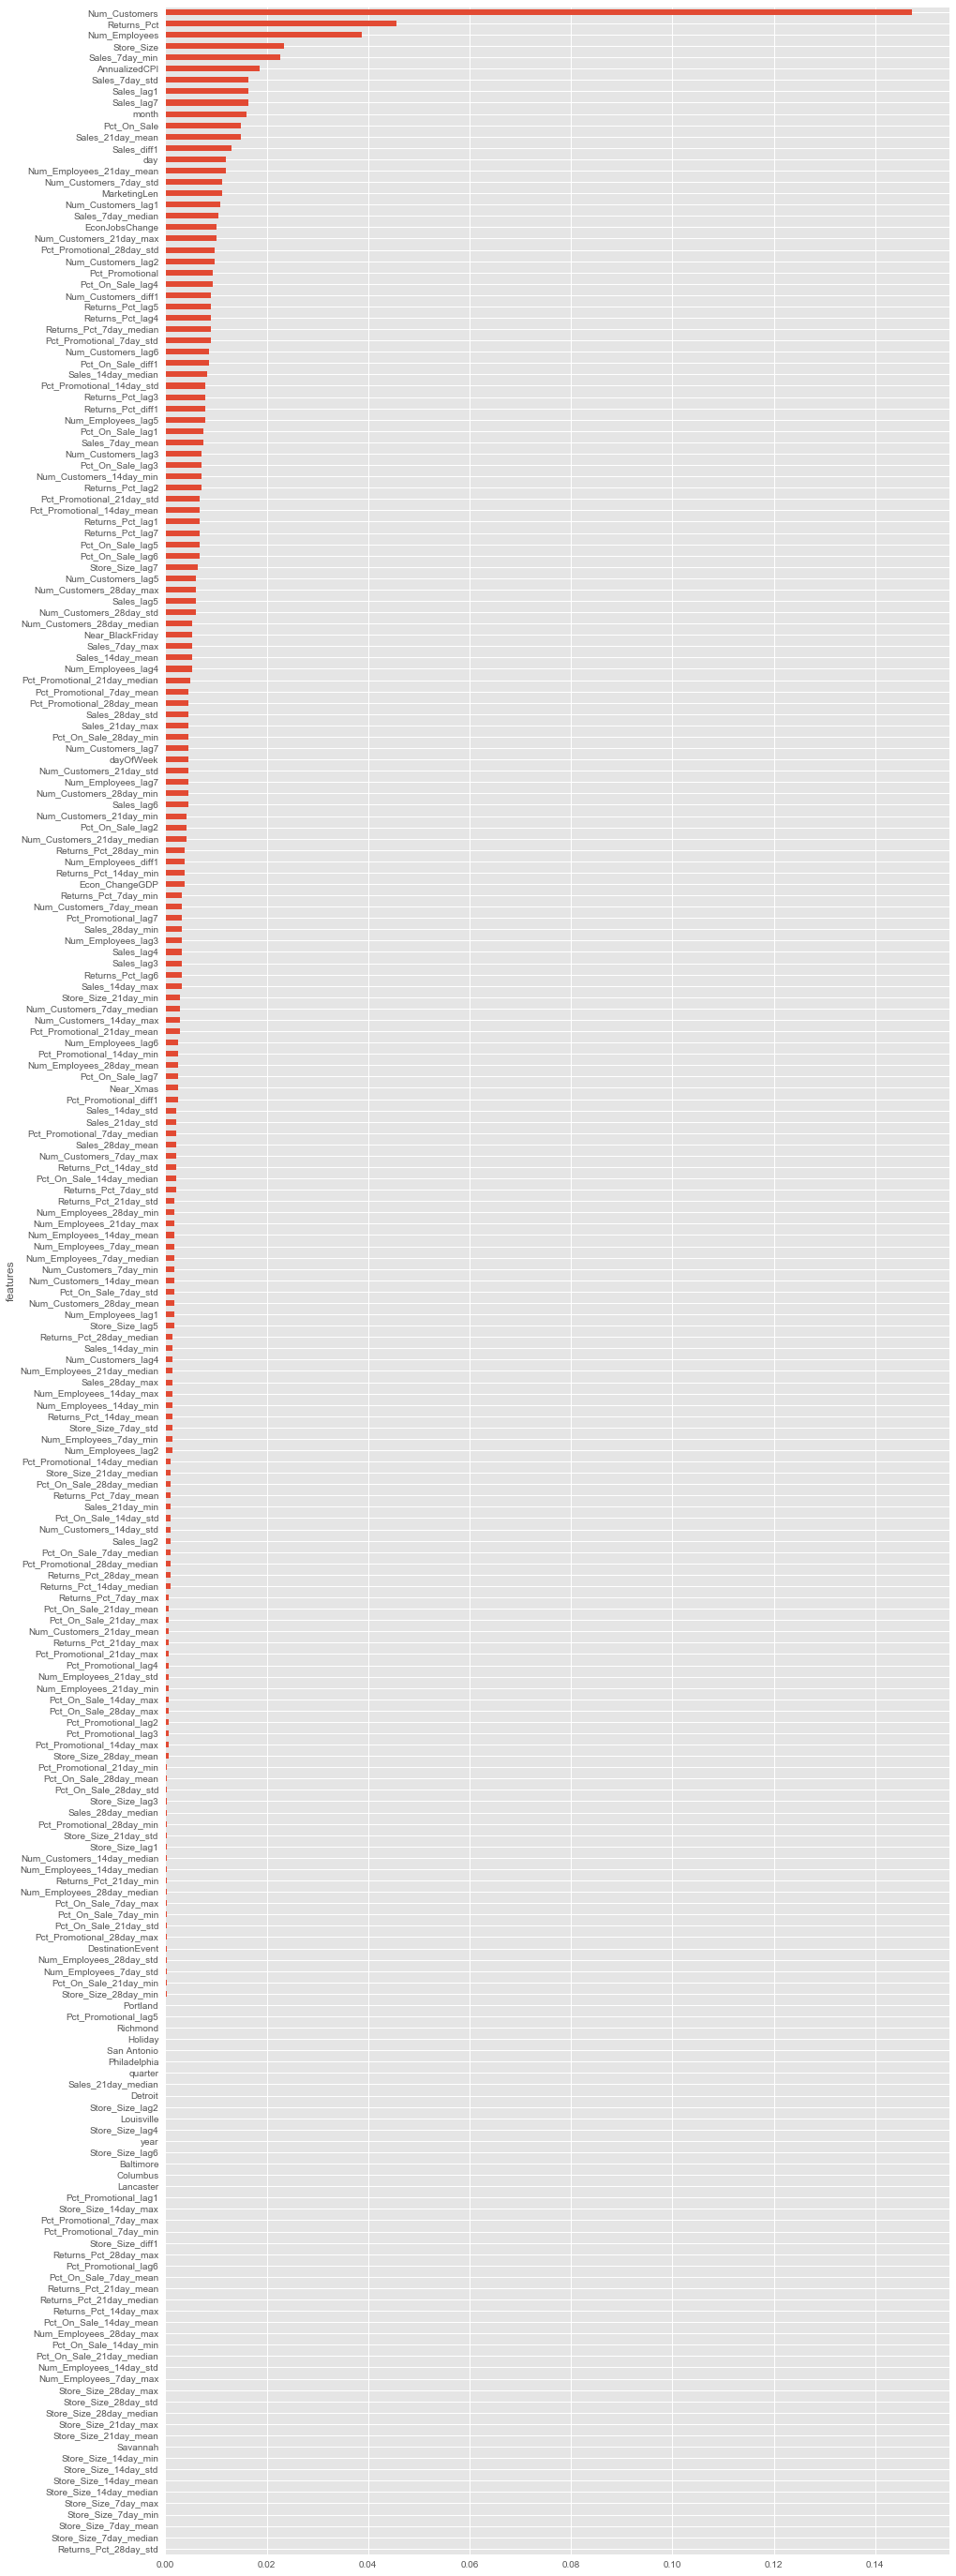

In [33]:
# Plotting feature importance

df_featImp = pd.DataFrame({'features': X_train.columns, 'importance': model.feature_importances_})
df_featImp = df_featImp.sort_values('importance').reset_index(drop=True)

plt.figure()
df_featImp.plot(kind='barh', x='features', y='importance', legend=False, figsize=(15, 50))


In [34]:
# Plotting actual vs prediction for XGBoost

df_plot = test[['Store','Date','Sales']]
df_plot['Prediction'] = y_pred


In [36]:
data = [dict(
  type = 'scatter',
  name = 'Actual',
  x = df_plot.Date,
  y = df_plot.Sales,
  mode = 'markers+lines',
  transforms = [dict(
    type = 'groupby',
    groups = df_plot.Store
  )]
),
       dict(
  type = 'scatter',
  name = 'Prediction',
  x = df_plot.Date,
  y = df_plot.Prediction,
  mode = 'markers+lines',
  transforms = [dict(
    type = 'groupby',
    groups = df_plot.Store
  )]
)]


layout = {
    'title': 'Actual vs Prediction Sales Across locations',
    'yaxis': {'title': 'Sales'},
    'xaxis': {'title': 'Date'}
}


py.iplot({'data': data, 'layout': layout}, validate=False)